In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import least_squares
import sys
from vector_class import TripleVector
from scipy.optimize import curve_fit


# Parameters

In [43]:
A_min = 1e10 # Bq
A_max = 2e10 # Bq
Ab = 500 # Bq
h = 10 # m
dt = 100 # the pause on each point od the grid in s
x_max = 4 # m
y_max = 4 # m
grid = [8, 8] # m
n_bins = 20

radiation = [A_min, A_max, Ab, dt]
detector = [h, x_max, y_max, grid]

## Flyover

In [33]:
def Intensity(source, x, y, h, dt): # it equals to the activity multiplied by the time of measuring
    u, v, A0 = source[0], source[1], source[2] # u, v are the coordinates of the source and A0 is its activity
    return (A0*dt) / ((x - u)**2 + (y - v)**2 + h**2)

def point_source(x_max, y_max, A_min, A_max, x_min=0, y_min=0):
    if (x_min == 0) and (y_min == 0):    
        return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]
    else:
        return [random.uniform(x_min, x_max), random.uniform(y_min, y_max), random.uniform(A_min, A_max)]

def flyover(radiation, detector, source = []):
    A_min, A_max, Ab, dt = radiation[0], radiation[1], radiation[2], radiation[3]
    h, x_max, y_max, grid = detector[0], detector[1], detector[2], detector[3]
    N_x, N_y = grid[0], grid[1]
    square_x, square_y = (2*x_max)/N_x, (2*y_max)/N_y

    grid_x, grid_y = np.zeros((N_x, N_y)), np.zeros((N_x, N_y)) 
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_x))
    # ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_y))
    if len(source) == 0:
        source = point_source(x_max, y_max, A_min, A_max)
    intensities = np.zeros((int(N_x), int(N_y)))
    # grid_x, grid_y = np.meshgrid(xs, ys)
    n, m = N_x - 1, 0
    y = -y_max + square_y/2
    i = 1
    max_intensity = {"number": [0], "postion": [[(0, 0), (0, 0)]]}
    for x in xs:
        while abs(y) <= y_max:
            intensity = Intensity(source, x, y, h, dt)
            if Ab* dt > intensity:
                intensities[n, m] = 0
            else:
                intensities[n, m] = intensity - Ab*dt
            grid_x[n, m] = x; grid_y[n, m] = y
            if max_intensity["number"][0] < intensity:
                max_intensity["number"], max_intensity["position"] = [intensity], [[(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            elif max_intensity["number"][0] == intensity:
                max_intensity["position"] = [max_intensity["position"][0], [(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            y += (square_y)*i
            n -= 1*i
        n += 1*i
        i = i * (-1)
        y += (square_y)*i
        m += 1

    return {"intensities_array": intensities, "source": source, "grid_x": grid_x, "grid_y": grid_y, "hotspot": max_intensity["position"], "square_x": square_x, "square_y": square_y}

measurement = flyover(radiation, detector)
# measurement["intensities_array"]



## Location from measurement - Levenberg-Marquardt method

### Scipy least square

In [4]:
# Using the Levenberg-Marquardt method with scipy least squares
def locationLM(measurement, radiation, detector):
    A_min, A_max, dt = radiation[0], radiation[1], radiation[3]
    h = detector[0]
    hotspot = measurement["hotspot"]
    x_min, x_max = hotspot[0][0][0], hotspot[0][0][1]
    y_min, y_max = hotspot[0][1][0], hotspot[0][1][1]
    def I(source, x, y):
        return Intensity(source, x, y, h, dt)

    grid_x, grid_y = measurement["grid_x"], measurement["grid_y"]
    Is = measurement["intensities_array"]

    def fun(source):
        return (I(source, grid_x, grid_y) - Is).flatten()

    source0 = point_source(x_max, y_max, A_min, A_max, x_min, y_min)
    res = least_squares(fun, source0, method="lm")

    return res["x"]

measurement = flyover(radiation, detector)
sourceLM = locationLM(measurement, radiation, detector)



### Scipy curve fit

In [107]:
# Also location with LM method, only now using the curve_fit scipy.optimize function 
def locationCF(measurement, radiation, detector):
    Is, grid_x, grid_y, hotspot = measurement['intensities_array'], measurement['grid_x'], measurement['grid_y'], measurement["hotspot"] # in example Z, here Is
    A_min, A_max, dt = radiation[0], radiation[1], radiation[3]
    h = detector[0]


    
    x_min, x_max = hotspot[0][0][0], hotspot[0][0][1]
    y_min, y_max = hotspot[0][1][0], hotspot[0][1][1]

    XY = np.vstack((grid_x.ravel(), grid_y.ravel()))
    source0 = point_source(x_max, y_max, A_min, A_max, x_min, y_min)
    
    def intensity(x, y, u, v, A0): # it equals to the activity multiplied by the time of measuring u, v are the coordinates of the source and A0 
        return (A0*dt) / ((x - u)**2 + (y - v)**2 + h**2) # is its activity

    def _intensity(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += intensity(x, y, *args[i*3:i*3+3])
        return arr

    # Testing the sigma/absolute_sigma for scipy curve_fit
    dIs = Is * 0.02
    D_Is = np.ones(Is.shape)*0.2

    popt, pcov = curve_fit(_intensity, XY, Is.ravel(), source0, sigma = dIs.ravel(), absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))

    return popt, perr



### TUTORIALS

#### Scipy least square minimization example  

In [ ]:
def h(theta, x, y, h):
    return theta[2] * (x - theta[0])**2 + theta[3] * (y - theta[1])**2 - h

xs = np.linspace(-1, 1, 20)
ys = np.linspace(-1, 1, 20)
dt = 10
gridx, gridy = np.meshgrid(xs, ys)
x0 = 0.1; y0 = -0.15; a = 1; b = 2; noise = 0.1
hs = h([x0, y0, a, b], gridx, gridy, 10) * dt
# hs += noise * np.random.default_rng().random(hs.shape)

print(hs)

def fun(theta):
    return (h(theta, gridx, gridy, 10) * dt - hs).flatten()

theta0 = [0, 0, 1, 2]
res3 = least_squares(fun, theta0)

# print(hs)


#### Scipy curve fit for 2D data example

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The two-dimensional domain of the fit.
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape) # In our example this are the measured intesities Is

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
       arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr

# Initial guesses to the fit parameters.
guess_prms = [(0, 0, 1, 1, 2),
              (-1.5, 5, 5, 1, 3),
              (-4, -1, 1.5, 1.5, 6),
              (4, 1, 1.5, 1.5, 6.5)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
for i in range(len(popt)//5):
    fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fit, cmap='plasma')
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
ax.set_zlim(-4,np.max(fit))
plt.show()



## Combine

In [81]:
# combines the detector flyover and the location detection
def combination(radiation, detector, source= []):
    measurement = flyover(radiation, detector, source)
    sourceLM = locationLM(measurement, radiation, detector)
    sourceCF, stDev = locationCF(measurement, radiation, detector)[0], locationCF(measurement, radiation, detector)[1]
    return {'measurement': measurement, 'source_locationLM': sourceLM, 'source_locationCF': sourceCF, "sourceCF_stDev": stDev}


## Visualization

[1.31086759e-05 1.30700692e-05 6.84938626e+02]


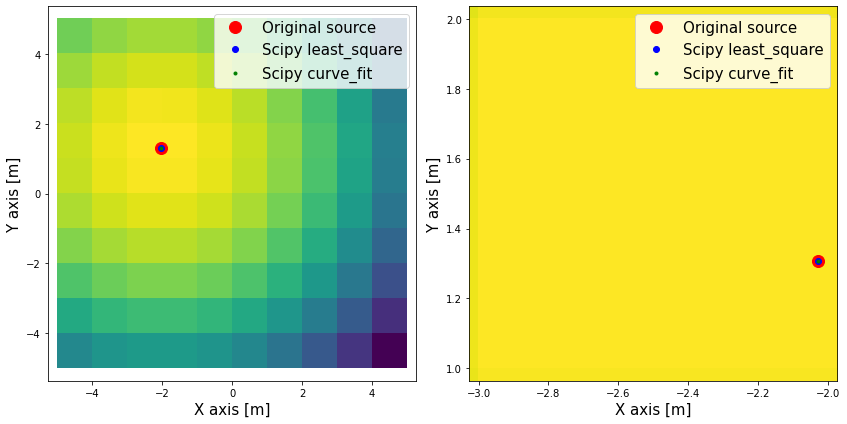

In [58]:
def visualize(measurement, x_max, y_max, points):
    X, Y = measurement["source"][0], measurement["source"][1]
    u1, v1 = points[0][0], points[0][1]
    u2, v2 = points[1][0], points[1][1]
    # print((u1, v1), (u2, v2))

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
    im = ax1.imshow(measurement["intensities_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax1.plot(X, Y, "o", color = 'r', ms=12, label = "Original source")
    ax1.plot(u1, v1, "o", color = 'b', ms=6, label = "Scipy least_square")
    ax1.plot(u2, v2, "o", color = 'g', ms=3, label = "Scipy curve_fit")

    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax1.legend(fontsize = 15)

    ax2.imshow(measurement["intensities_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax2.plot(X, Y, "o", color = 'r', ms=12, label = "Original source")
    ax2.plot(u1, v1, "o", color = 'b', ms=6, label = "Scipy least_square")
    ax2.plot(u2, v2, "o", color = 'g', ms=3, label = "Scipy curve_fit")
    ax2.axis("equal")
    ax2.set_xlim(measurement["hotspot"][0][0][0], measurement["hotspot"][0][0][1])
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(measurement["hotspot"][0][1][0], measurement["hotspot"][0][1][1])
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)    

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]
    # print(measurement["intensities_array"], '\n', measurement["grid_x"], '\n', measurement["grid_y"])


data = combination(radiation, detector)

print(data['sourceCF_stDev'])

visualize(data["measurement"], detector[1], detector[2], [data["source_locationLM"], data["source_locationCF"]])


## Analysis

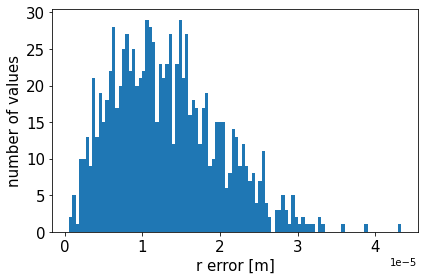

6.840804743175233e-06


In [54]:
def dist_points(point1, point2):
    return (point1 - point2).magnitude()

# run simulation n_sim times and keep track of the distance between the original source and estimated source. Plot a histogram for the values.
def stDev(radiation, detector, n_sim):
    R = []
    for i in range(n_sim):
        data = combination(radiation, detector)
        original = (data["measurement"])["source"]
        estimate = data["source_locationLM"]
        R.append(dist_points(TripleVector(original[0], original[1], 0), TripleVector(estimate[0], estimate[1], 0)))
 
    plt.hist(np.array(R), 100)
    plt.xlabel("r error [m]", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("number of values", fontsize = 15)
    plt.yticks(fontsize = 15)

    #plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    # plt.savefig("graphics/dr_hist.jpg")
    plt.show()

    d_R = np.std(R)

    return d_R

n_sim = 1000
print(stDev(radiation, detector, n_sim))

# Code description

u = 0.917473150437555 (1 ± 0.6198342582445293) m
v = -2.8878887421852513 (1 ± -0.1987244220743811) m
A0 = 12010690566.835854 (1 ± 0.002914682073705713) Bq


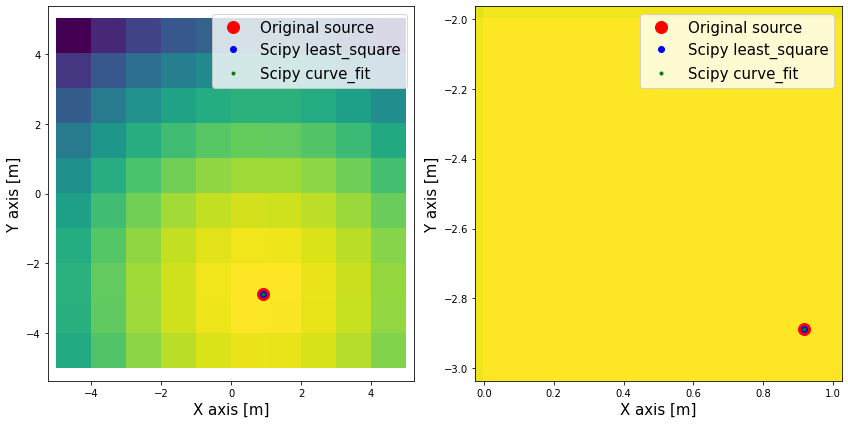

In [111]:
# DESCRIPTION OF THE CODE

# In comparisson to the code in simple_SPS.ipynb there are a few minor changes. The intensity function is defined diferently. It takes into
# consideration two points, the source of the radiation and the position of a measurement. Flyover() is very similar to the older version 
# it just uses the new intensity and also the activity of the source is randomly generated - it is one of the parameters which we are fitting.

# locationLM() is the major chenge. We use the scipy least square Levenberg-marquardt method to minimize the square residuals of the model 
# intensity and the measured intensity. Through the minimization we can output the paramaters which we are searching for - u, v and A0 (x/y 
# coordinates of the source and its intensity).

# visualize() shows us that this method is much more accurate then the previously used location searching method.

# PARAMETERS
A_min = 1e10; A_max = 1.5e10 # borders between which the activity of the source is randomly selected 
Ab = 500 # background activity in Bq
h = 40 # hight at which the detector flies over in m
x_max = 5 # Size of the area of flyover in x direction in m
y_max = 5 # Size of the area of flyover in y direction in m
grid = [10, 10] # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the
                # number of radioactive decays. The first number is the number of these areas in x direction and the second is the number in y
                # direction, components must be INTEGERS!
D_t = 100 # the pause on each point od the grid in s
n_bins = 20 # number of bins in the histogram made by find_source()

# Combinig the parameters into a list so that the data is more compacted
radiation = [A_min, A_max, Ab, D_t]
detector = [h, x_max, y_max, grid]

data = combination(radiation, detector)

print("u =", data["source_locationCF"][0], "(1", r'±', str(data['sourceCF_stDev'][0]/data["source_locationCF"][0]) + ")", "m")
print("v =", data["source_locationCF"][1], "(1", r'±', str(data['sourceCF_stDev'][1]/data["source_locationCF"][1]) + ")", "m")
print("A0 =", data["source_locationCF"][2], "(1", r'±', str(data["sourceCF_stDev"][2]/data["source_locationCF"][2]) + ")", "Bq")

visualize(data["measurement"], detector[1], detector[2], [data["source_locationLM"], data["source_locationCF"]])
